In [1]:
import sys
sys.path.append('../python_packages_static/')
import os
import gzip
import shutil
import pandas as pd
import numpy as np
import rasterio
from pyproj import CRS
from affine import Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import re

## Now that `modpath_run_data` is setup with the necessary files, we'll For each set of modpath files (NE, W, and S), we'll run one modpath simulation for each of the 358 parameter realizations contained in `modpath_par_ens.csv`. This notebooks skips to the results from the paper, with all realizations combined in numpy array files. 

In [2]:
mc_path = '../output/modpath/'
outpath = os.path.join('../modpath_run_data', 'postproc')

In [3]:
if not os.path.exists(outpath):
    os.mkdir(outpath)

### get list of priority wells, and locations

In [7]:
wells_df = pd.read_csv('../processed_data/2009-2016_ave_pumping.csv')
wells_df = wells_df.loc[wells_df.WellType == 'Priority']
priority_wells = wells_df.ID_Well.tolist()
priority_wells

['SV_193', 'SV_227', 'U__55', 'U_917', 'U___7', 'U___8', 'SV_407', 'SV_487']

In [8]:
well_dat_df = pd.read_csv('../neversink_mf6/wel_000.dat', delim_whitespace=True)
well_dat_df = well_dat_df.loc[well_dat_df.boundname.isin(priority_wells)]

well_dat_df['i_zb'] = well_dat_df['i'] - 1
well_dat_df['j_zb'] = well_dat_df['j'] - 1

particle_ys = [y for y in well_dat_df['i_zb']]
particle_xs = [x for x in well_dat_df['j_zb']]

In [9]:
#  set True to make a single combined probabilistic capture geotiff - combines capture for all wells
make_ca=True


#  set True to make a raster showing the standard deviation of the water table across all MODPATH realizations
proc_heads=True

# Create rasters from MODPATH MC results

### water table standard deviation raster

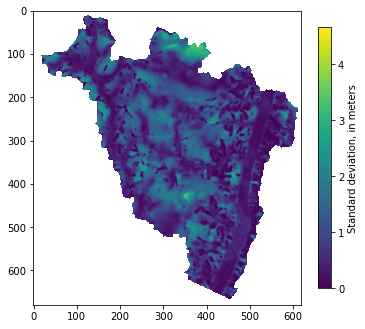

In [10]:
if proc_heads is True:
    mp_mc_wt_file = os.path.join(mc_path, 'baserat_heads.npy.gz') # numpy array file with water table arrays from each modpath realization 

    f = gzip.GzipFile(mp_mc_wt_file, "r")
    wt_reals = np.load(f)
    wt_reals.shape

    h_std = wt_reals.std(axis=2)

    h_std[h_std>1e10]=-9999.
   
    outfile = 'heads_std.tif'
    raster_outpath = os.path.join(outpath, outfile)

    dataset = rasterio.open(
        raster_outpath, 
        'w', 
        driver='GTiff',
        height = h_std.shape[0], 
        width = h_std.shape[1],
        count=1,
        nodata = -9999.0,
        dtype=str(h_std.dtype),
        crs = CRS.from_epsg(5070),
        transform=Affine(50.0, 0.0, 1742955.0,
                         0.0, -50.0, 2292285.0),
    )

    dataset.write(h_std, 1)
    dataset.close()
    
    fig, ax = plt.subplots(figsize=(6,6))
    h_std_plot = h_std.copy()
    h_std_plot[h_std_plot==-9999.]=np.nan
    im = ax.imshow(h_std_plot)
    fig.colorbar(im, label='Standard deviation, in meters', shrink=0.8)

## Probablistic particle tracking rasters to priority wells
### Contributing recharge to priority wells on one raster

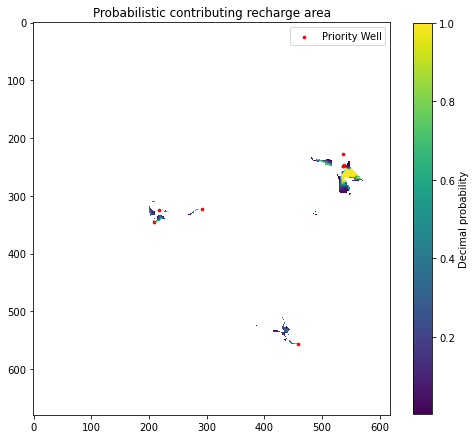

In [11]:
if make_ca:
    endpoints_file = os.path.join(mc_path, 'baserat.npy.gz') # numpy array file with startipoint cells of particles ending in priority well nodes from each modpath realization 

    f = gzip.GzipFile(endpoints_file, "r")
    mp_endpoints = np.load(f)
    mp_endpoints.shape
    
    mp_grid = np.zeros((680, 619)) 
    nonzero_mc_count = 0
    
    for i in range(mp_endpoints.shape[2]):
        real_endpoints = mp_endpoints[:,:,i]
        mp_grid += real_endpoints
        nonzero_mc_count += 1
        
    mp_grid /= nonzero_mc_count
    
    #  plot results with priority wells
    grid_for_plotting = mp_grid.copy()
    grid_for_plotting[grid_for_plotting == 0.]=np.nan
    
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(grid_for_plotting)
    fig.colorbar(im, label='Decimal probability', shrink=0.9) 
    ax.scatter(particle_xs, particle_ys, c='r', label='Priority Well', s=7)
    ax.set_title('Probabilistic contributing recharge area')
    ax.legend()
    
    #  export results as geotiff
    out_grid = mp_grid.copy()
    out_grid[out_grid == 0.] = -9999.
    
    outfile = 'mp_mc_combined.tif'
    raster_outpath = os.path.join(outpath, outfile)

    dataset = rasterio.open(
        raster_outpath, 
        'w', 
        driver='GTiff',
        height = out_grid.shape[0], 
        width = out_grid.shape[1],
        count=1,
        nodata = -9999.0,
        dtype=str(out_grid.dtype),
        crs = CRS.from_epsg(5070),
        transform=Affine(50.0, 0.0, 1742955.0,
                         0.0, -50.0, 2292285.0),
    )

    dataset.write(out_grid, 1)
    dataset.close()
